# Installing packages

In [1]:
!pip install nlp
!pip install captum
!pip install bio
!pip install evaluate
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git


  Cloning https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to /tmp/pip-req-build-8ikrxg6g
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git /tmp/pip-req-build-8ikrxg6g
  Resolved https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to commit 03084c54b64019ba5fa0b620b9c70ad81123e458
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.9 MB/s eta 0:00:00:00:01
  Created wheel for parrot: filename=parrot-1.0-py3-none-any.whl size=8590 sha256=e80691b03afd6a916491db6c53ec0afeba868607d253e25eb9a96848379b4934
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfjk41es/wheels/e8/ee/2a/4d6a4b2a5c37f5f750e90fa79d2ad84f444fba9b050ecbbe6d
Successfully built parrot


In [3]:

from typing import Dict

# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time


# NLP related libraries
import re
import nlp
import torch
from torch.utils.data import Dataset
import transformers
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics, pipeline,
                          AutoTokenizer, AutoModelForSequenceClassification,
                          T5ForConditionalGeneration, T5TokenizerFast,
                          BartTokenizer, BartForConditionalGeneration,
                          AutoModelForSeq2SeqLM, PegasusTokenizer, 
                          PegasusForConditionalGeneration, BigBirdPegasusModel,
                          BigBirdPegasusForConditionalGeneration)
from parrot import Parrot


# Alignment
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

# BERT score
from evaluate import load

# Supressing warnings
import warnings
warnings.filterwarnings('ignore')



from sklearn.metrics import auc
from scipy.stats import gaussian_kde

transformers.__version__

/opt/conda/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


'4.45.1'

In [4]:
np.random.seed(123)
train_dataset = nlp.load_dataset('imdb', split='train')

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:

class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
#             token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])   

In [8]:
train_dataset = TrainerDataset(train_dataset["text"],
                               train_dataset["label"], tokenizer)

In [9]:
a = [1, 2, 3,4]
b = ["a", "b", "c","d"]
np.random.seed(123)
np.random.shuffle(a)
np.random.seed(123)
np.random.shuffle(b)
a,b

([4, 1, 2, 3], ['d', 'a', 'b', 'c'])

# Alignment measures

In [10]:
# rouge
# blue

In [11]:



string1 = 'my channel is youtube dot com slash example and then I also do live streaming on twitch.'
string2 = 'my channel is youtube.com/example and then I also do livestreaming on twitch.'

alignments = pairwise2.align.globalxx(string1.split(), 
                                      string2.split(),
                                      gap_char=['-']
                                     )
print(format_alignment(*alignments[0]))

alignments2 = pairwise2.align.globalxx(string1.split(), 
                                      string1.split(),
                                      gap_char=['-']
                                     )
print(format_alignment(*alignments2[0]))
print(f"Score: {alignments[0].score/alignments2[0].score}") #<- less is btter


my channel is youtube dot com slash example          -          and then I also do live streaming       -       on twitch. 
 |    |     |                                                    |    |  |   |   |                               |    |    
my channel is    -     -   -    -      -    youtube.com/example and then I also do  -       -     livestreaming on twitch. 
  Score=10

my channel is youtube dot com slash example and then I also do live streaming on twitch. 
 |    |     |    |     |   |    |      |     |    |  |   |   |   |      |      |    |    
my channel is youtube dot com slash example and then I also do live streaming on twitch. 
  Score=17

Score: 0.5882352941176471


# BERT Score

In [12]:

bertscore = load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["goodbye here", "admiral skywalker"]
results = bertscore.compute(predictions=predictions, references=references, lang="en", model_type="distilbert-base-uncased", verbose=0)
results

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

{'precision': [0.8584095239639282, 0.6368807554244995],
 'recall': [0.8584095239639282, 0.6684491634368896],
 'f1': [0.8584095239639282, 0.652283251285553],
 'hashcode': 'distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.45.1)'}

In [13]:
positives = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
n_positive = len(positives)
sentences = str(positives[np.random.randint(n_positive)])

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)


tokenizer_bigbird = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")
paraphraser_bigbird = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")

tokenizer_pegasus = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
paraphraser_pegasus = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")

paraphraser_t5small = T5ForConditionalGeneration.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")
tokenizer_t5small = T5TokenizerFast.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")

paraphraser_t5 = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")
tokenizer_t5 = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")

tokenizer_bert = BartTokenizer.from_pretrained('facebook/bart-base')
paraphraser_bert = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

tokenizer_config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.31G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [14]:

tokenizer = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
paraphraser = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")

# input sentences
positives = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
n_positive = len(positives)
sentences = str(positives[np.random.randint(n_positive)])
print(sentences,end="\n\n\n")

def paraphrase(sentences, paraphraser, tokenizer, cat = False):
    # Paraphrase the sentences. Reviews are too long it's best to paraphrase one sentence at a time
    output = []
    reference = re.split(r'[.?!]', sentences)
    for sentence in reference:
        if len(sentence)>0 :

            # Tokenize the input sentence
            input_ids = tokenizer.encode(sentence, return_tensors='pt')

            if len(input_ids[0])>=50:
                output.append(sentence)
                continue
                
            # Generate paraphrased sentence
            paraphrase_ids = paraphraser.generate(input_ids, num_beams=5, max_length=1024, early_stopping=True, no_repeat_ngram_size=3)
        
            # Decode and print the paraphrased sentence
            paraphrase = tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True, verbose=0)
            if cat:
                print(f"Original: {sentence}")
                print(f"Paraphrase: {paraphrase}")
                print()
            output.append(paraphrase)
        else:
            output.append(sentence)
    return output, reference


def paraphrase_parrot(sentences,cat=False):
    # Paraphrase the sentences. Reviews are too long it's best to paraphrase one sentence at a time
    output = []
    reference = re.split(r'[.?!]', sentences)
    for sentence in reference:
        if len(sentence)>0 :

            if len(sentence)>=100:
                output.append(sentence)
                continue
                
            # Generate paraphrased sentence
            paraphrase = parrot.augment(input_phrase=sentence)
            if paraphrase==None:
                paraphrase = sentence
            else:
                paraphrase, _ = paraphrase[0]
            output.append(paraphrase)
            if cat:
                print(f"Original: {sentence}")
                print(f"Paraphrase: {paraphrase}")
                print()
            
        else:
            output.append(sentence)
    return output, reference


def paraphrase_bigbird(sentences,cat=False):
    # Paraphrase the sentences. Reviews are too long it's best to paraphrase one sentence at a time
    output = []

    if len(sentences)>0 :
        input_ids = tokenizer_bigbird.encode(sentences, return_tensors='pt')
            
        # Generate paraphrased sentence
        paraphrase_ids = paraphraser_bigbird.generate(input_ids)
        
        output = tokenizer_bigbird.decode(paraphrase_ids[0], skip_special_tokens=True, verbose=0)
        
        if cat:
            print(f"Original: {sentences}")
            print(f"Paraphrase: {output}")
            print()
        
    
    return output, sentences


# output, reference = paraphrase(sentences, paraphraser, tokenizer, True)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Three horror stories based on members of a transgressive Hindu cult that return home but changed in some way. In the first story our former cult member is now in an insane asylum and is visited by a reported who wants to find out about what went on at the cult. Somewhat slow going as story is told in flashbacks while the two sit on chairs and face each other. Reporter is particularly interested in what lead to the death of the participants. What seemed rather boring suddenly turns very exciting with a surprising twist in the story. Things get quite bloody.<br /><br />Second story has a violent young criminal visiting a psychiatrist for mandatory therapy. The patient seems to have some type of agenda but the psychiatrist is up to the task. Again, things slow down a bit and get weird. Then there's a strange twist in the story that is very well written and surprising.<br /><br />Final story deals with spiritual healer who claims to be able to remove the persons illness from them with his 

In [15]:
output, _ = paraphrase(str(positives[np.random.randint(n_positive)]), paraphraser_t5small, tokenizer_t5small)
output

['There are no director I like more than Mamoru Oshii. There is no director there is more than mamoru oshii?',
 'sadly, even though he directed quite a few films that gained huge international attention, there are still a fair few of his films that have slipped through the cracks.',
 "I love Tachiguishi, and even though I loved it to bits, it's not hard to see why distributors in the West are somewhat reluctant to release it.",
 'In between his big and serious films, Oshii is known to do some smaller and quirkier projects, including his big films, and his big projects, br />Br/>In between his large and serious movies, he is known for a smaller and queirkier project.',
 'While Tachiguishi definitely falls into this category, Oshii has really outdone himself with this one, creating something that is very hard to classify, even as a freaky Japanese flick.',
 'Go figure figure: Go figure Figure: Go Go Figure Figures: Go Figures.',
 'At its very core lies a documentary not quite unlike Otak

In [16]:


def evaluate_paraphrase(sentences, paraphraser, tokenizer, name):
    
    start = time.time()
    if name ==  "bigbird":
        
        output, reference = paraphrase_bigbird(sentences)
    elif name == "parrot":
        output, reference = paraphrase_parrot(sentences)
    else:
        
        output, reference = paraphrase(sentences, paraphraser, tokenizer, False)
    time_stat = time.time()-start


    

    if name ==  "bigbird":
        output_cleaned = [output]
        reference_cleaned = [reference]
        alignment_score =  0
    else:
        # Remove empty sentences
        output_cleaned = []
        reference_cleaned = []
        alignment_score = []
        for i in range(len(reference)):
            if len(reference[i])!=0 and reference[i]!=" " and len(output[i])!=0 and output[i]!=" ":
                output_cleaned.append(output[i])
                reference_cleaned.append(reference[i])
                alignments = pairwise2.align.globalxx(reference[i].split(), 
                                              output[i].split(),
                                              gap_char=['-']
                                             )
    
    
                alignments2 = pairwise2.align.globalxx(reference[i].split(), 
                                                      reference[i].split(),
                                                      gap_char=['-']
                                                     )
                alignment_score.append(alignments[0].score/alignments2[0].score)




    results = bertscore.compute(predictions=output_cleaned, references=reference_cleaned, lang="en", model_type="distilbert-base-uncased", verbose=0)

    measures = {"paraphraser": name,
                "time [s]":time_stat,
                "avg alignment": np.mean(alignment_score)}
    for k,v in results.items():
        if k != 'hashcode':
            measures["avg BERT Score "+ k]=np.mean(v)
            
    result = " ".join(output_cleaned)
    
    alignments = pairwise2.align.globalxx(sentences.split(), 
                                          result.split(),
                                          gap_char=['-']
                                         )


    alignments2 = pairwise2.align.globalxx(sentences.split(), 
                                          sentences.split(),
                                          gap_char=['-']
                                         )

    measures["entire sentence alignment"]=(alignments[0].score/alignments2[0].score)
    results = bertscore.compute(predictions=[result], references=[sentences], lang="en", model_type="distilbert-base-uncased", verbose=0)
    for k,v in results.items():
        if k != 'hashcode':
            measures["entire sentence BERT Score "+ k]=v[0]
            
    measures["sentence"] = sentences
    measures["paraphrase"] = result
    measures["view"] = output
    
    
    return measures




In [17]:
np.random.seed(123)
results = []
for sentences in [str(positives[np.random.randint(n_positive)]) for _ in range(30)]:
    for paraphraser, tokenizer, name in [
                                        (None, None, "bigbird"),
                                         (paraphraser_pegasus, tokenizer_pegasus, "Pegasus"),
                                         (paraphraser_t5small, tokenizer_t5small, "t5-small"),
                                         (paraphraser_t5, tokenizer_t5, "t5"),
                                         (paraphraser_bert, tokenizer_bert, "BERT"),
                                        (None, None, "parrot")
                                         
                                        ]:
        results.append(evaluate_paraphrase(sentences, paraphraser, tokenizer, name))
res = pd.DataFrame(results)

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values ), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
(
res.tail(10).style.apply(highlight_max, axis=0, props='background-color:green;', subset=["avg BERT Score precision", "avg BERT Score recall", "avg BERT Score f1", "entire sentence BERT Score precision", "entire sentence BERT Score recall", "entire sentence BERT Score f1"])
         .apply(highlight_min, axis=0, props='background-color:green;', subset=['time [s]', 'avg alignment', "entire sentence alignment"])
)

Attention type 'block_sparse' is not possible if sequence_length: 413 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 60). Running this sequence through the model will result in indexing errors


,paraphraser,time [s],avg alignment,avg BERT Score precision,avg BERT Score recall,avg BERT Score f1,entire sentence alignment,entire sentence BERT Score precision,entire sentence BERT Score recall,entire sentence BERT Score f1,sentence,paraphrase,view
170,t5-small,9.044442,0.835544,0.966392,0.960320,0.963024,0.879433,0.983598,0.968351,0.975915,"I enjoyed the innocence of this film and how the characters had to deal with the reality of having a powerful animal in their midst. The gorilla looks just terrific, and the eyes were especially lifelike. It's even a little scary at times and should have children slightly frightened without going over the top. Rene Russo plays her role wonderfully feminine. Usually these type of Hollywood films that take place in the past feel the need to create a straw-man villain but the only adversary is the gorilla. It's an interesting look at how close some animals are to humans, how they feel the same emotions we do, and yet how we really can't treat them just like people because they aren't. Not many films venture into this territory and it's worth seeing if you want to contemplate the human-animal similarity.","I enjoyed the innocence of this film and how the characters had to deal with the reality of having a powerful animal in their midst. The gorilla looks just terrific, and the eyes were especially lifelike. The Gorilla looks really great. It's even a little scary at times and should have children slightly frightened without going over the top. Rene Russo plays her role wonderfully feminine. Usually these type of Hollywood films that take place in the past feel the need to create a straw-man villain but the only adversary is the gorilla. How close some animals are to humans, how they feel the same emotions we do, and yet how we really can't treat them just like people because they aren't. Is it worth watching if you want to contemplate the human-animal similarity?","['I enjoyed the innocence of this film and how the characters had to deal with the reality of having a powerful animal in their midst.', 'The gorilla looks just terrific, and the eyes were especially lifelike. The Gorilla looks really great.', ""It's even a little scary at times and should have children slightly frightened without going over the top."", 'Rene Russo plays her role wonderfully feminine.', 'Usually these type of Hollywood films that take place in the past feel the need to create a straw-man villain but the only adversary is the gorilla.', ""How close some animals are to humans, how they feel the same emotions we do, and yet how we really can't treat them just like people because they aren't."", 'Is it worth watching if you want to contemplate the human-animal similarity?', '']"
171,t5,16.538178,0.965382,0.990121,0.991665,0.990891,0.957447,0.995398,0.994069,0.994733,"I enjoyed the innocence of this film and how the characters had to deal with the reality of having a powerful animal in their midst. The gorilla looks just terrific, and the eyes were especially lifelike. It's even a little scary at times and should have children slightly frightened without going over the top. Rene Russo plays her role wonderfully feminine. Usually these type of Hollywood films that take place in the past feel the need to create a straw-man villain but the only adversary is the gorilla. It's an interesting look at how close some animals are to humans, how they feel the same emotions we do, and yet how we really can't treat them just like people because they aren't. Not many films venture into this territory and it's worth seeing if you want to contemplate the human-animal similarity.","I enjoyed the innocence of this film and how the characters had to deal with the reality of having a powerful animal in their midst . The gorilla looks just terrific, and the eyes were especially lifelike. It's even a little scary at times and should have children slightly scared without going over the top . Rene Russo plays her role wonderfully feminine 

In [18]:
def cut_off_kde(X, lower_limit=None, upper_limit=None):
    
    """ Function used to generate points of bounded KDE plot

    Args:
        X (array): Data point
        lower_limit (float, optional): lower bound of KDE plot. Defaults to None.
        upper_limit (float, optional): upper bound of KDE plot. Defaults to None.

    Returns:
        (list, list): (list of x coordinates,  list of y coordinates)
    """
    
    # Setting plot limits if they were not provided and don't use limits if they are significantly smaller than smallest observation
    if lower_limit == None:
        lower_limit = np.min(X) - np.std(X)
    else:
        lower_limit = np.max([ np.min(X) - np.std(X), lower_limit])
        
    if upper_limit == None:
        upper_limit = np.max(X) + np.std(X)
    else:
        upper_limit = np.min([np.max(X) + np.std(X), upper_limit])
    x2 = np.linspace(lower_limit, upper_limit, 1001)
    
    # Fitting gaussian KDE  
    if np.min(X)==np.max(X):
        return [], []
    else:
        kde_full = gaussian_kde(X)
        y2 = kde_full(x2)
    
    # Scaling resulting distribution
    area_within_bounds = auc(x2, y2)
    y2 /= area_within_bounds
    return x2, y2

def plot_kde_bounded(X, lower_limit=None, upper_limit=None, label = None):
    """ Function used to plot bounded KDE

    Args:
        X (array): Data point
        lower_limit (float, optional): lower bound of KDE plot. Defaults to None.
        upper_limit (float, optional): upper bound of KDE plot. Defaults to None.
        label: plot label
    Returns:
        None
    """
    x, y = cut_off_kde(X, lower_limit, upper_limit)
    if len(x)==0:
        return
    line = plt.plot(x, y, label=label)
    color = line[0].get_color()
    plt.vlines(x[-1], 0, y[-1], color=color)
    plt.vlines(x[0], 0, y[0], color=color)


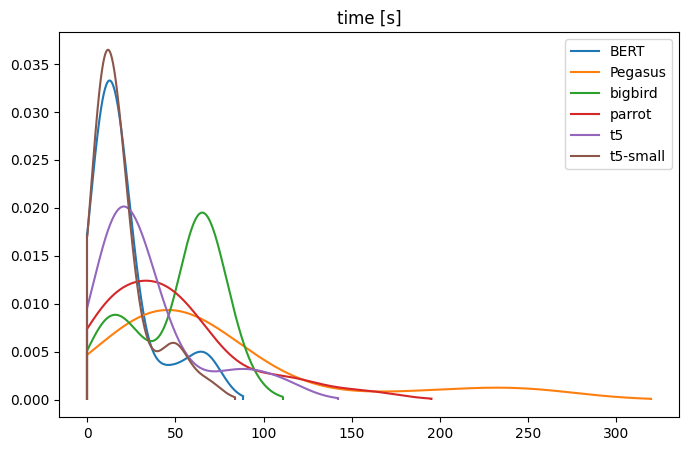

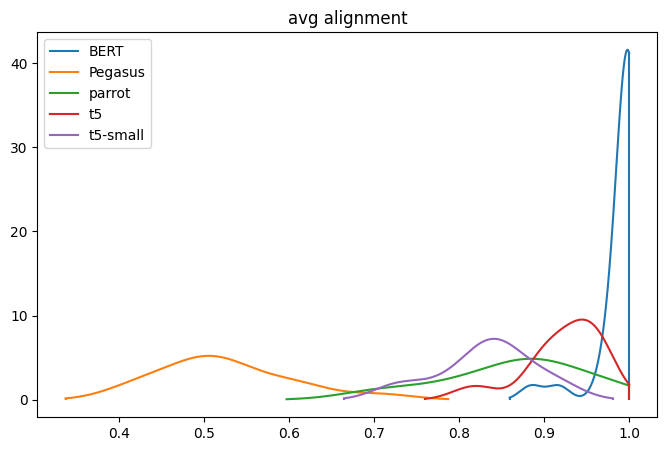

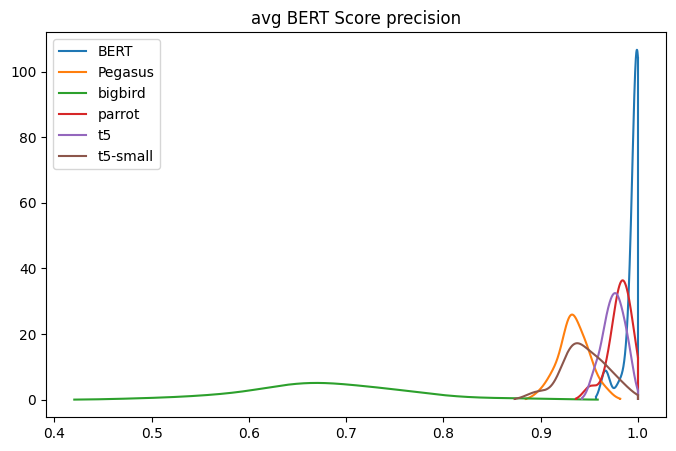

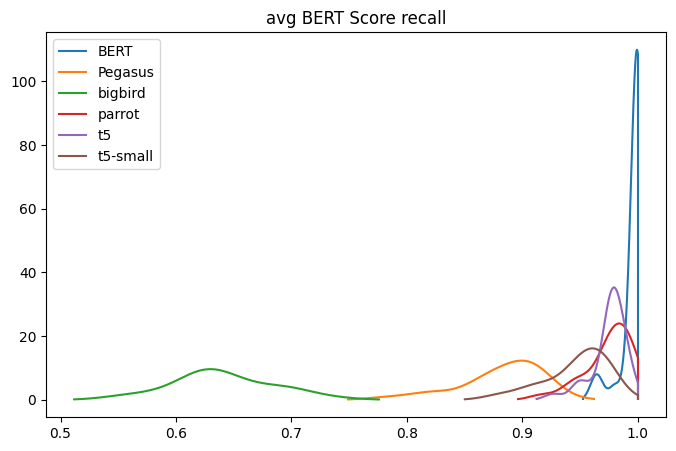

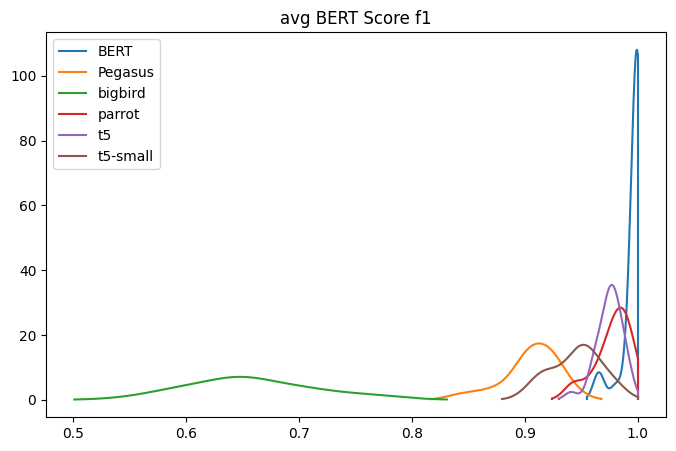

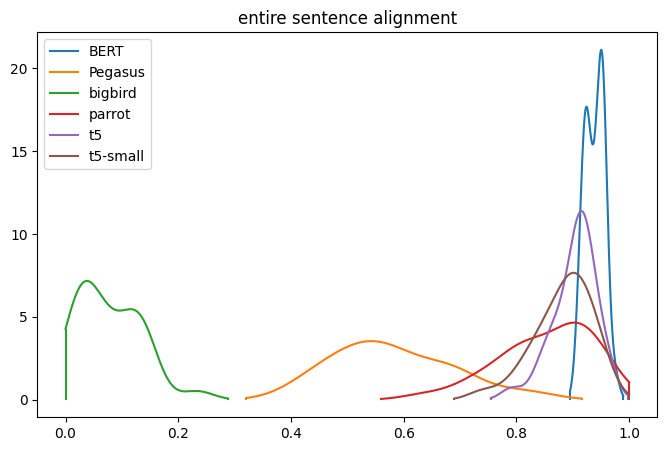

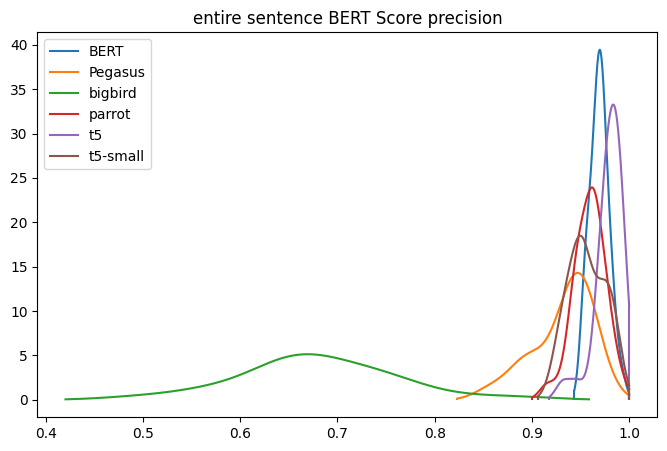

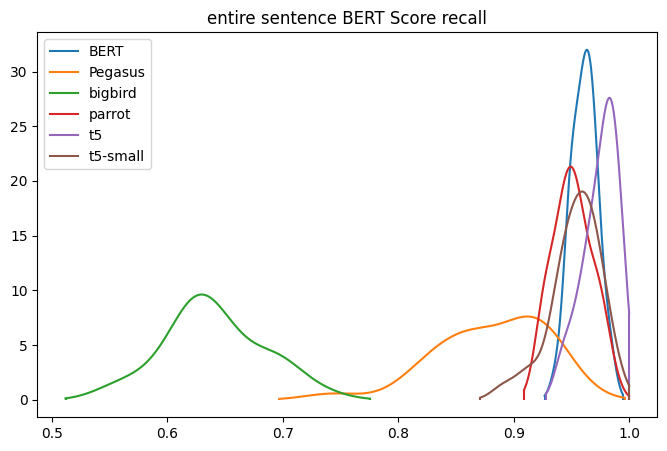

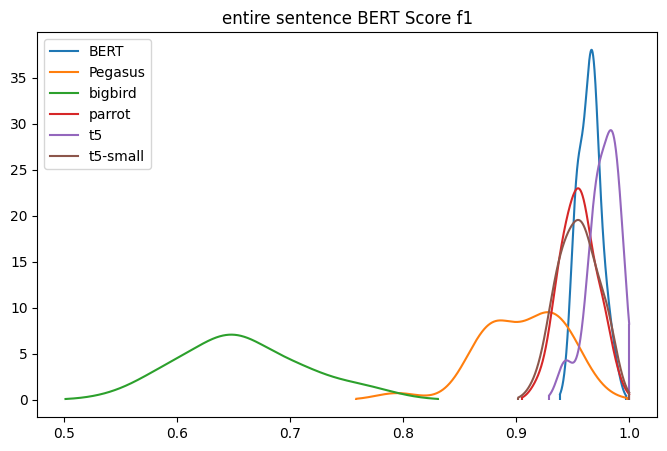

In [27]:
import seaborn as sns
for measure in res.columns[:-3]:
    if measure in ["paraphraser", "sentence", "paraphrase"]:
        continue
    plt.figure(figsize=(8, 5))
    for par in np.unique(res.paraphraser):
        df = res[res.paraphraser==par][measure]
        plot_kde_bounded(df, lower_limit=0, upper_limit = None if measure=="time [s]" else 1, label=par)
    plt.legend()
    plt.title(measure)
    plt.show()

In [20]:
def get_time(time):
    result = ""
    if time//3600 > 0:
        result += str(int(time//3600)) + " h  "
        time %= 3600
    if time//60 > 0:
        result += str(int(time//60)) + " m  "
        time %= 60
    if time//1 > 0:
        result += str(np.round(time,2)) + " s  "
    return result


In [21]:
for par in np.unique(res.paraphraser):
    text = f"Average time {par}:"
    for _ in range(25-len(text)):
        text += " "
        
    print(text+f"{get_time(np.mean(res[res.paraphraser==par]['time [s]']))}")

Average time BERT:       20.43 s  
Average time Pegasus:    1 m  12.9 s  
Average time bigbird:    50.22 s  
Average time parrot:     46.37 s  
Average time t5:         33.94 s  
Average time t5-small:   18.88 s  


In [22]:
for par in np.unique(res.paraphraser):
    text = f"Average time {par}:"
    for _ in range(25-len(text)):
        text += " "
        
    print(text+f"{get_time(np.mean(res[res.paraphraser==par]['time [s]'])*9500)}")

Average time BERT:       53 h  55 m  19.11 s  
Average time Pegasus:    192 h  22 m  47.46 s  
Average time bigbird:    132 h  30 m  43.38 s  
Average time parrot:     122 h  21 m  9.03 s  
Average time t5:         89 h  34 m  11.55 s  
Average time t5-small:   49 h  49 m  20.09 s  
